In [ ]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import warnings

# Preprocessing & Models
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
import umap

# Metrics & Interpretation
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.manifold import trustworthiness
import shap

warnings.filterwarnings('ignore')

In [ ]:
# ==============================================================================
# 2. CONFIGURATION - MODIFY THIS SECTION FOR A NEW DATASET
# ==============================================================================

CONFIG = {
    "file_path": "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv",
    "target_column": "Survived",
    "id_column": "PassengerId",
    "features_to_drop": ["Name", "Ticket", "Cabin"]
}


# CONFIG = {
#     "file_path": "/content/pisa_spain_sample_v2.csv", # We are using pre-loaded dataframes
#     "target_column": None, # We are using pre-loaded dataframes
#     "id_column": None, # Column used for merging data and labels
#     "features_to_drop": [] # No additional features to drop from the data_df besides the id column
# }

# import zipfile
# import os

# zip_file_path = '/content/covtype.csv.zip'
# extracted_dir = '/content/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_dir)

# print(f"File extracted to: {extracted_dir}")
# CONFIG = {
#     "file_path": "/content/covtype.csv",
#     "target_column": "Cover_Type",
#     "id_column": None, # This dataset does not have an ID column
#     "features_to_drop": []
# }



# CONFIG = {
#     "file_path": None, # Set to None for datasets fetched directly
#     "dataset_name": "mnist_784", # Add dataset name for identification
#     "target_column": "class", # Target column for MNIST
#     "id_column": None, # MNIST does not have an ID column
#     "features_to_drop": [] # Use all pixel columns as features
# }
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)
# data, target = mnist.data, mnist.target

# # Use the already loaded data and target variables
# df = data.copy()
# df[CONFIG['target_column']] = target



In [ ]:
# ==============================================================================
# 3. HELPER FUNCTIONS
# ==============================================================================
def find_optimal_k(data, max_k=10):
    """
    Finds the optimal number of clusters (k) for k-means using the Elbow Method.

    Args:
        data: The data to be clustered (e.g., the 2D embedding).
        max_k: The maximum number of clusters to test.

    Returns:
        The optimal k value.
    """
    print("\n[INFO] Finding optimal k using the Elbow Method...")
    inertias = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    # Heuristic to find the elbow point automatically
    # This is a simple approach; more complex ones exist
    # We look for the point with the maximum distance to a line between the first and last points.
    p1 = np.array([1, inertias[0]])
    p2 = np.array([max_k, inertias[-1]])

    distances = []
    for i in range(len(inertias)):
        p3 = np.array([i + 1, inertias[i]])
        distance = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        distances.append(distance)

    optimal_k = distances.index(max(distances)) + 1
    print(f"--> Optimal k identified as: {optimal_k}")
    return optimal_k

def calculate_kmeans_stability(data, k, n_iterations=20):
    """Calculates cluster stability for k-means using bootstrap resampling."""
    print(f"\n[INFO] Calculating cluster stability with {n_iterations} iterations...")
    all_labels = []
    for i in range(n_iterations):
        sample_indices = np.random.choice(data.shape[0], data.shape[0], replace=True)
        bootstrap_data = data[sample_indices]
        clusterer = KMeans(n_clusters=k, random_state=i, n_init='auto')
        clusterer.fit(bootstrap_data)
        full_data_labels = clusterer.predict(data)
        all_labels.append(full_data_labels)

    ari_scores = []
    for i in range(len(all_labels)):
        for j in range(i + 1, len(all_labels)):
            ari_scores.append(adjusted_rand_score(all_labels[i], all_labels[j]))

    return np.mean(ari_scores) if ari_scores else 0.0

def extract_medoid_prototypes(X_original_df, X_processed, labels):
    """
    Finds the most representative actual data point (medoid) for each cluster.

    Args:
        X_original_df: The original DataFrame before scaling/encoding.
        X_processed: The scaled/encoded data used for clustering.
        labels: The cluster labels for each data point.

    Returns:
        A dictionary mapping each cluster label to its prototype's data.
    """
    prototypes = {}
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1: continue # Skip noise if present

        # Get the indices of points in the current cluster
        idx_in_cluster = np.where(labels == label)[0]

        # Get the processed data points for this cluster
        cluster_points_processed = X_processed[idx_in_cluster]

        # Calculate the centroid of the processed points
        centroid = cluster_points_processed.mean(axis=0)

        # Find the point in the cluster that is closest to the centroid
        distances = np.linalg.norm(cluster_points_processed - centroid, axis=1)
        medoid_cluster_idx = np.argmin(distances)

        # Get the original index of this prototype point in the full dataset
        prototype_original_idx = idx_in_cluster[medoid_cluster_idx]

        # Store the original, un-processed data for this prototype
        prototypes[label] = X_original_df.iloc[prototype_original_idx]

    return prototypes

[INFO] Using dataset: https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
--> Identified 5 numerical features.
--> Identified 2 categorical features.
[INFO] Building and applying preprocessing pipeline...
Data processed successfully. Shape: (891, 10)

[INFO] Applying dimensionality reduction...
[INFO] Using t-SNE for dimensionality reduction...
[INFO] Applying k-means clustering on the 2D embedded data from t-SNE...

[INFO] Finding optimal k using the Elbow Method...


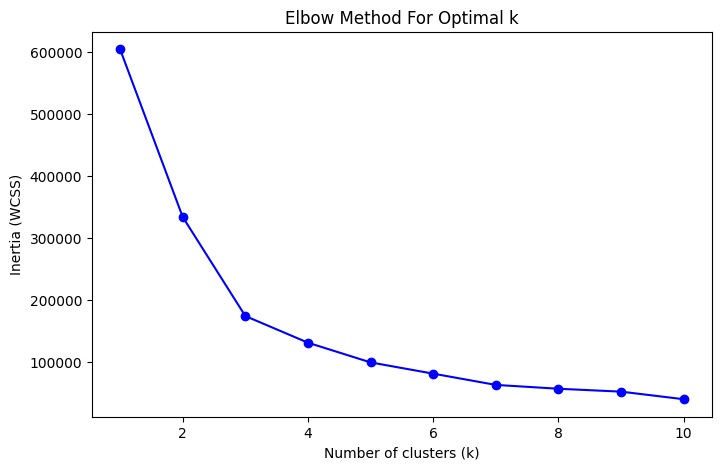

--> Optimal k identified as: 3
--> Found 3 clusters.

[INFO] Calculating performance metrics...

[INFO] Calculating cluster stability with 20 iterations...
--> Trustworthiness of t-SNE: 0.9876
--> Silhouette Score of k-means: 0.4972
--> Cluster Stability (Adjusted Rand Index): 0.9161

[INFO] Generating visualization...


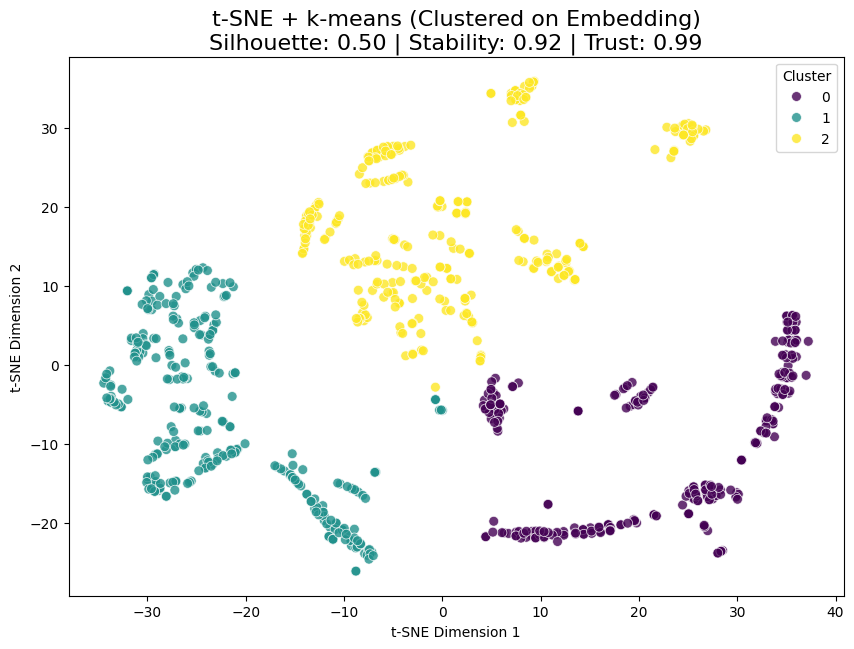


[INFO] Generating interpretations...

--- Interpretation Method 1: Cluster Average Profile (Centroid) ---
         Pclass    Age  SibSp  Parch   Fare  Survived
cluster                                              
0          3.00  29.22   0.14   0.02  10.10      0.13
1          1.29  36.94   0.36   0.25  64.70      0.47
2          2.70  22.01   1.01   0.82  19.59      0.52

--- Interpretation Method 2: Most Representative Example (Medoid) ---

Cluster 0 Prototype (original data row 81):
PassengerId                             82
Survived                                 1
Pclass                                   3
Name           Sheerlinck, Mr. Jan Baptist
Sex                                   male
Age                                   29.0
SibSp                                    0
Parch                                    0
Ticket                              345779
Fare                                   9.5
Cabin                                  NaN
Embarked                          

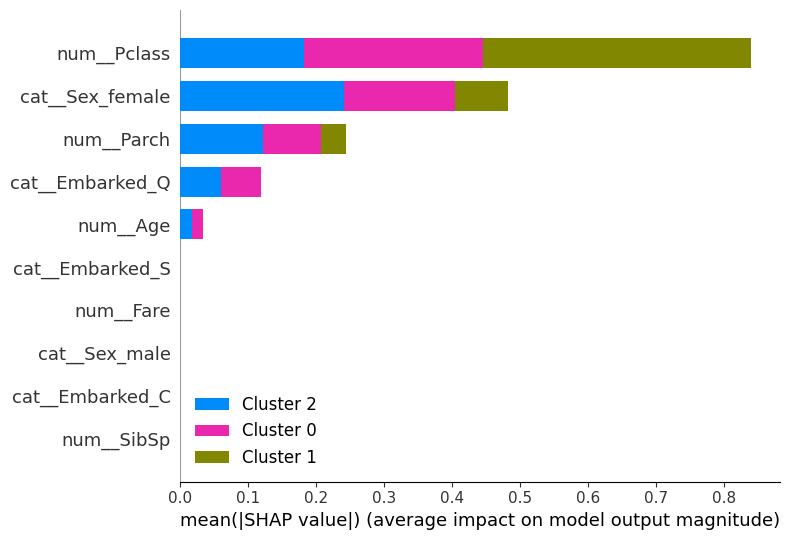

In [ ]:
# ==============================================================================
# 4. MAIN SCRIPT
# ==============================================================================
if __name__ == '__main__':
    # --- Step 1: Data Loading and Feature Identification ---
    print(f"[INFO] Using dataset: {CONFIG['file_path']}")

    # Load the data from the specified file path
    try:
        df = pd.read_csv(CONFIG['file_path'])
    except FileNotFoundError:
        print(f"[ERROR] File not found at {CONFIG['file_path']}")
        exit() # Exit if the file is not found
    except Exception as e:
        print(f"[ERROR] An error occurred while loading the file: {e}")
        exit()


    features_to_exclude = CONFIG['features_to_drop'] + [CONFIG['id_column'], CONFIG['target_column']]
    features_to_exclude = [f for f in features_to_exclude if f is not None and f in df.columns]
    potential_features_df = df.drop(columns=features_to_exclude)

    numerical_features = potential_features_df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = potential_features_df.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"--> Identified {len(numerical_features)} numerical features.")
    print(f"--> Identified {len(categorical_features)} categorical features.")

    # --- Step 2: Preprocessing ---
    print("[INFO] Building and applying preprocessing pipeline...")
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[('num', numerical_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)],
        remainder='drop'
    )
    X_processed = preprocessor.fit_transform(potential_features_df)
    feature_names = preprocessor.get_feature_names_out()
    print(f"Data processed successfully. Shape: {X_processed.shape}")

    # --- Step 3: Dimensionality Reduction ---
    print("\n[INFO] Applying dimensionality reduction...")
    if X_processed.shape[0] < 10000:
        print("[INFO] Using t-SNE for dimensionality reduction...")
        reducer = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
        embedding = reducer.fit_transform(X_processed)
        reduction_method = "t-SNE"
    else:
        print("[INFO] Using UMAP for dimensionality reduction...")
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(X_processed)
        reduction_method = "UMAP"


    # --- Step 4: Clustering with k-means on Embedded Data ---
    print(f"[INFO] Applying k-means clustering on the 2D embedded data from {reduction_method}...")
    k = find_optimal_k(embedding, max_k=10)
    kmeans_clusterer = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans_clusterer.fit_predict(embedding)
    print(f"--> Found {k} clusters.")

    # --- Step 5: Calculate All Metrics ---
    print("\n[INFO] Calculating performance metrics...")
    # Trustworthiness is specific to t-SNE, skip if using UMAP
    trust_score = trustworthiness(X_processed, embedding, n_neighbors=15) if reduction_method == "t-SNE" else None
    sil_score = silhouette_score(embedding, cluster_labels)
    stability_score = calculate_kmeans_stability(embedding, k=k)

    if trust_score is not None:
        print(f"--> Trustworthiness of {reduction_method}: {trust_score:.4f}")
    print(f"--> Silhouette Score of k-means: {sil_score:.4f}")
    print(f"--> Cluster Stability (Adjusted Rand Index): {stability_score:.4f}")

    # --- Step 6: Visualization ---
    print("\n[INFO] Generating visualization...")
    df['cluster'] = cluster_labels
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df['cluster'], palette="viridis", s=50, alpha=0.8)
    title = f'{reduction_method} + k-means (Clustered on Embedding)\nSilhouette: {sil_score:.2f} | Stability: {stability_score:.2f}'
    if trust_score is not None:
        title += f' | Trust: {trust_score:.2f}'
    plt.title(title, fontsize=16)
    plt.xlabel(f"{reduction_method} Dimension 1"); plt.ylabel(f"{reduction_method} Dimension 2"); plt.legend(title='Cluster'); plt.show()

    # --- Step 7: Interpretation ---
    print("\n[INFO] Generating interpretations...")

    # A. Cluster Prototypes (Centroid - The Average Profile)
    print("\n--- Interpretation Method 1: Cluster Average Profile (Centroid) ---")
    prototype_cols = numerical_features
    if CONFIG['target_column'] and CONFIG['target_column'] in df.columns:
        prototype_cols = numerical_features + [CONFIG['target_column']]
    centroid_prototypes = df.groupby('cluster')[prototype_cols].mean()
    print(centroid_prototypes.round(2))

    # B. Cluster Prototypes (Medoid - The Best Real Example)
    print("\n--- Interpretation Method 2: Most Representative Example (Medoid) ---")
    medoid_prototypes = extract_medoid_prototypes(df, X_processed, cluster_labels)
    for label, data in medoid_prototypes.items():
        print(f"\nCluster {label} Prototype (original data row {data.name}):")
        print(data)

    # C. Decision Tree Surrogate Model
    print("\n--- Interpretation Method 3: Decision Tree Surrogate ---")
    surrogate_model = DecisionTreeClassifier(max_depth=4, random_state=42)
    surrogate_model.fit(X_processed, cluster_labels)
    surrogate_accuracy = accuracy_score(cluster_labels, surrogate_model.predict(X_processed))
    print(f"--> Surrogate model accuracy: {surrogate_accuracy:.2%}")
    tree_rules = export_text(surrogate_model, feature_names=list(feature_names))
    print(tree_rules)

    # D. SHAP Explanations
    print("\n--- Interpretation Method 4: SHAP Summary Plot ---")
    explainer = shap.TreeExplainer(surrogate_model)
    shap_values = explainer.shap_values(X_processed)
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    shap.summary_plot(shap_values, X_processed_df, plot_type="bar", class_names=[f"Cluster {i}" for i in range(k)])

    # --- Step 8: Logging Results ---
    # print("\n[INFO] Saving results...")
    # df.to_csv('final.csv', index=False)